# PRACTICE

#### Vladimir Trukhaev & Ingrid Sancho

In [1]:
#imports 
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import json
from collections import Counter

In [2]:
#updating/downloading stop words
nltk.download('stopwords')
#reading data
doc = "dataset_tweets_WHO.txt"
with open(doc, 'r') as file:
    data = json.load(file)
    
#initializing dictionary "my_dict" where value is the tweet text and key its id
keylist = []
for key in data:
    keylist.append(key)

my_dict = {}
docs_info = {}

for i in keylist:
    my_dict[i] = None
    docs_info[i] = None
    
for key in data:
    #initializing my_dict
    tweet = []
    for i in data[key]["full_text"]:
        tweet.append(i)
    tweet1 = "".join(tweet)
    my_dict[key] = tweet1
 
"""
    #creting docs_info
    tweet = data[key]["full_text"]
    username = data[key]["user"]["name"]
    date = data[key]["created_at"]
    hashtags = data[key]["entities"]["hashtags"]
    likes = data[key]["favorite_count"]
    retweets = data[key]["retweet_count"]
    try:
        url = data[key]["entities"]["media"][0]["expanded_url"]
    except: #sometimes we weren't able to find the url in the data, then:
        url = "https://twitter.com/WHO/status/%s" % (data[key]["id_str"])
    
    info = {"tweet": tweet, "username": username, 
            "date": date, "hashtags": hashtags, 
            "likes": likes,"retweets": retweets, "url": url}
    docs_info[key] = info
"""
    
 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'\n    #creting docs_info\n    tweet = data[key]["full_text"]\n    username = data[key]["user"]["name"]\n    date = data[key]["created_at"]\n    hashtags = data[key]["entities"]["hashtags"]\n    likes = data[key]["favorite_count"]\n    retweets = data[key]["retweet_count"]\n    try:\n        url = data[key]["entities"]["media"][0]["expanded_url"]\n    except: #sometimes we weren\'t able to find the url in the data, then:\n        url = "https://twitter.com/WHO/status/%s" % (data[key]["id_str"])\n    \n    info = {"tweet": tweet, "username": username, \n            "date": date, "hashtags": hashtags, \n            "likes": likes,"retweets": retweets, "url": url}\n    docs_info[key] = info\n'

# Part 1: Text Processing

In [3]:
def lowering(d):
    """
    Transforming tweet text (values in dictionary) in lowercase
    
    Argument:
    d -- dictionary where tweets are stored as values
    
    Returns:
    d -- dictionary with tweets transformed to lowercase as values
    """
    for key in d:
        d[key] = d[key].lower()
    return d

def cleaning(d):
    """
    Removing anything that is not alphanumeric
    
    Argument:
    d -- dictionary where tweets are stored as values
    
    Returns:
    d -- dictionary with tweets without any non alphanumeric character
    """
    for key in d:
        d[key] = ["".join(re.sub(r'[^A-Za-z0-9 #]', ' ', i) for i in d[key])]
    return d

def tokenize(d):
    """
    Tokenizing the tweets, in other words, splitting text by "words"
    
    Argument:
    d -- dictionary where tweets are stored as values
    
    Returns:
    d -- dictionary with lists of words as values
    """
    for key in d:
        for sentence in d[key]:
            d[key] = sentence.split()
    return d

def stpwords(d):
    """
    Removing stopwords, which are very common words that do not contain meaning
    
    Argument:
    d -- dictionary where list of words of tweets are stored as values
    
    Returns:
    d -- dictionary with lists of words as values, now with no stopwords
    """
    languages = ["english", "spanish", "french"]
    for language in languages:
        stop_words = set(stopwords.words(language))
        for key in my_dict:
            my_dict[key] = [word for word in my_dict[key] if word not in stop_words]
    return d

def stemming(d):
    """
    Stemming tweets, which means to keep only the "root" of each word
    
    Argument:
    d -- dictionary where list of words of tweets are stored as values
    
    Returns:
    d -- dictionary with lists of words as values, now stemmed words
    """
    stemmer = PorterStemmer()
    for key in my_dict.keys():
        my_dict[key] = [stemmer.stem(word) for word in my_dict[key]]
    return d

In [4]:
#running every function for our dictionary of tweets "my_dict"
my_dict = lowering(my_dict)
my_dict = cleaning(my_dict)
my_dict = tokenize(my_dict)
my_dict = stpwords(my_dict)
my_dict = stemming(my_dict)

# Part 2:Indexing and Evaluation

## 11/11/21

#### Vladimir Trukhaev & Ingrid Sancho

### 1. Indexing

In [5]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time

#### 1.1 Index Implementation

In [6]:
def create_index(my_dict):
    """
    Implement the inverted index
    
    Argument:
    my_dict -- dictionary with word lists of tweets as values and tweet id as key
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    for doc in my_dict:
        current_tweet_index = {} # create the index for the current tweet and store it in current_tweet_index
        for position, term in enumerate(my_dict[doc]): # terms contains page_title + page_text. Loop over all terms
            try:
                  # if the term is already in the index for the current page (current_tweet_index)
                  # append the position to the corresponding list
                   current_tweet_index[term][1].append(position)  
            except:
                  # Add the new term as dict key and initialize the array of positions and add the position
                    current_tweet_index[term]=[doc, array('I',[position])] #'I' indicates unsigned int (int in Python)
              
          #merge the current page index with the main index
        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)                
                    
    return index

In [7]:
start_time = time.time()
index = create_index(my_dict)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2 )))

Total time to create the index: 0.21 seconds


#### 1.2 Querying the Index

In [8]:
def build_terms(query): #used to process query text
    """
    Preprocess the input query removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    query -- string (text) to be preprocessed
    
    Returns:
    query - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    query=  query.lower() ## Transform in lowercase
    query=  query.split() ## Tokenize the text to get a list of terms
    query=[word for word in query if not word in stop_words]  ##eliminate the stopwords
    query=[stemmer.stem(word) for word in query] ## perform stemming
    
    return query

In [9]:
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    
    Argument:
    query -- string (text) to split and search by
    index -- inverted index (in a form of a dictionary)
    
    Returns:
    docs - a list of ids
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

In [10]:
#defining docs_info from original data
doc = "dataset_tweets_WHO.txt"
with open(doc, 'r') as file:
    data = json.load(file)
    
#initializing dictionary "docs_info" where value are all the information text and key is the tweet's id
keylist = []
for key in data:
    keylist.append(key)

docs_info = {}
    
for i in keylist:
    docs_info[i] = None
    
for key in data:
    tweet = data[key]["full_text"]
    username = data[key]["user"]["name"]
    date = data[key]["created_at"]
    hashtags = data[key]["entities"]["hashtags"]
    likes = data[key]["favorite_count"]
    retweets = data[key]["retweet_count"]
    try:
        url = data[key]["entities"]["media"][0]["expanded_url"]
    except: #sometimes we weren't able to find the url in the data, then:
        url = "https://twitter.com/WHO/status/%s" % (data[key]["id_str"])
    
    info = {"tweet": tweet, "username": username, 
            "date": date, "hashtags": hashtags, 
            "likes": likes,"retweets": retweets, "url": url}
    docs_info[key] = info
    

#### 1.3. Add Ranking with TF-IDF

In [11]:
def create_index_tfidf(my_dict, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    my_dict -- collection of Wikipedia articles
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Pyhon dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    idf = defaultdict(float)
    for doc in my_dict:
        current_tweet_index = {}
        for position, term in enumerate(my_dict[doc]): # terms contains page_title + page_text. Loop over all terms
            try:
                  # if the term is already in the index for the current page (current_tweet_index)
                  # append the position to the corresponding list
                   current_tweet_index[term][1].append(position)  
            except:
                  # Add the new term as dict key and initialize the array of positions and add the position
                    current_tweet_index[term]=[doc, array('I',[position])] #'I' indicates unsigned int (int in Python)
              
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_tweet_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_tweet_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting)/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] = tf[term] # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/len(df[term]))), 4)

    return index, tf, df, idf

In [12]:
start_time = time.time()
num_documents = len(my_dict)
index, tf, df, idf = create_index_tfidf(my_dict, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 97.15 seconds


In [13]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
  
        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] =  query_terms_count[term]/len(terms)*idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs

In [14]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf)
    return ranked_docs

In [15]:
def rank_query(query):
    ranked_docs = search_tf_idf(query, index)
    top = 10

    print("\n======================\nTop {} results out of {} for".format(top, len(ranked_docs)), query,":\n")
    for d_id in ranked_docs[:top]:
        info_list = ["tweet","username","date","hashtags","likes","retweets","url"]
        print("DOC", d_id, "has been retrieved")
        for i in info:
            print(i,":",docs_info[d_id][i])
        print("\n")

In [16]:
rank_query("Covid España ola") 
rank_query("how many covid cases")
rank_query("mortalidad covid")
rank_query("Covid prevention")
rank_query("Pandemia mundial")


Top 10 results out of 38 for Covid España ola :

DOC 2257 has been retrieved
tweet : Q&amp;A #AskWHO on COVID-19 vaccines effectiveness https://t.co/FEdfOREhjn
username : World Health Organization (WHO)
date : Wed Jun 30 16:12:43 +0000 2021
hashtags : [{'text': 'AskWHO', 'indices': [8, 15]}]
likes : 219
retweets : 85
url : https://twitter.com/WHO/status/1410270080873598979


DOC 61 has been retrieved
tweet : RT @WHOPhilippines: Vaccines can’t stop #COVID19 alone, but by doing it all we can help protect ourselves and our loved ones against COVID-…
username : World Health Organization (WHO)
date : Mon Oct 11 04:39:10 +0000 2021
hashtags : [{'text': 'COVID19', 'indices': [40, 48]}]
likes : 0
retweets : 71
url : https://twitter.com/WHO/status/1447421491428143106


DOC 1959 has been retrieved
tweet : 💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉                 💉💉💉💉
💉💉💉💉                 💉💉💉💉

COVID-19 vaccines     COVID-19 vaccines
in 10 countries             in the rest of the 🌍

#VaccinEquity is 🗝️ to ending

url : https://twitter.com/WHO/status/1426242406853353474


DOC 200 has been retrieved
tweet : 🆕 WHO clinical case definition for post #COVID19 condition, also called 'long COVID' https://t.co/WoiLcwsgJX https://t.co/Z0olrHlWPC
username : World Health Organization (WHO)
date : Thu Oct 07 12:28:10 +0000 2021
hashtags : [{'text': 'COVID19', 'indices': [40, 48]}]
likes : 723
retweets : 373
url : https://twitter.com/WHO/status/1446089970758860801/photo/1



Top 10 results out of 4 for Pandemia mundial :

DOC 60 has been retrieved
tweet : RT @OPSOMSMexico: La pandemia de #COVID19 🦠 ha sido especialmente dura para nuestros 👨🏿‍⚕️👩🏻‍⚕️

Para reconocer sus experiencias, invitamos…
username : World Health Organization (WHO)
date : Mon Oct 11 04:39:41 +0000 2021
hashtags : [{'text': 'COVID19', 'indices': [33, 41]}]
likes : 0
retweets : 18
url : https://twitter.com/WHO/status/1447421622235942912


DOC 1557 has been retrieved
tweet : RT @opsoms: 🗣 Conversaciones EN VIVO: 

Lactancia materna durante 

### 2. Evaluation

In [17]:
import pandas as pd
import numpy as np

We will keep the answers for our 5 queries stored in a matrix
To compute Precision@K, Mean Average Precision and Mean Reciprocal Rank, we need binary relevance (relevant-1, not relevant-0). 

#### 2.1 Creating dataframe (with q_id, d_id, 'predicted_relevance', 'bin_y_true')

In [18]:
queries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]
query = []
docs =[]
for q in range (0, len(queries)):
    for d in my_dict.keys():
        query.append(q)
        docs.append(d)
    
df = pd.DataFrame(data={'q_id' :  query, 
                        'doc_id' : docs,
            'predicted_relevance': np.zeros(len(query)),
                        'bin_y_true': np.zeros(len(query))})
def prelevance_gtruth(query, index):
    """
    output is the list of score and id of relevant documents. 
    """
    query = build_terms(query)
    doc_vectors = defaultdict(lambda: [0] * len(query)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(query)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(query)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(query):  #termIndex is the index of the term in the query
        for doc_index, (doc, postings) in enumerate(index[term]):
            query_vector[termIndex] =  query_terms_count[term]/len(query)*idf[term]
            doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  
            
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    
    return doc_scores

def ground_truth(query, index):
    """
    m.
    """
    query = build_terms(query)
    doc_vectors = defaultdict(lambda: [0] * len(query)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(query)
    query_terms_count = collections.Counter(query)

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(query):
        for doc_index, (doc, postings) in enumerate(index[term]):
            query_vector[termIndex] =  query_terms_count[term]/len(query)*idf[term]
            doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  
            
    doc_scores =[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    truth = [x[1] for x in doc_scores]
    
    return truth

for q in range(0, len(queries)):
    output = prelevance_gtruth(queries[q], index)
    for r in range(0, len(output)):
        #Predictid_relevance is calculated as before, here we just update values in dataframe
        predicted = output[r][0]
        d_id = output[r][1]
        position = q*len(my_dict.keys()) + int(d_id) #finding exact row to update value
        df.at[position, 'predicted_relevance'] = predicted
        
        #SETTING GROUND TRUTH AS THE HALF OF THE MOST RELEVANT DOCUMENTS
        if r < len(output)/2: 
            df.at[position, 'bin_y_true'] = 1
    

In [19]:
truth = []
for i in range(len(queries)):
    truth.append(ground_truth(queries[i], index))
print(truth)

[['2257', '61', '1959', '4', '1577', '1568', '1169', '935', '1328', '200', '1536', '1464', '832', '1535', '931', '871', '300', '1135', '310', '304', '1045', '904', '2051', '199', '175', '1561', '1565', '1849', '1829', '173', '1325', '1310', '488', '2253', '1279', '1164', '1846', '1963'], ['200', '1135', '175', '1609', '2257', '61', '1959', '2119', '1517', '4', '1577', '1568', '1169', '935', '1328', '1536', '1464', '974', '832', '1535', '251', '931', '871', '300', '310', '304', '1045', '904', '2051', '199', '1561', '1565', '56', '1777', '1004', '1849', '1829', '173', '1325', '1310', '1333', '1294', '1221', '488', '2253', '1279', '1164', '1846', '1596', '1434', '1433', '1307', '128', '1963', '827', '807', '2336', '1520', '1195', '2397', '1782', '1400', '135', '1323', '1315', '629', '1543', '1998', '1516', '125', '9', '353', '1425', '927', '859', '782', '711', '703', '1824', '174', '1047', '2205', '880', '376', '2061', '2011', '631', '1934', '1727', '861', '1633', '78', '1399', '97', '578

In order to evaluate our algorithm we will use the dataframe search_results

In [20]:
search_results = df.copy()

#### 2.2 Evaluating algorithm

The dataframe "search_results" contains all the information in order to evaluate using the following techniques:

▪ Precision@K (P@K)


In [21]:
def precision_at_k(y_true, y_score, k = 10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)[::1]
    y_true = np.take(y_score, order)
    relevant = y_true/k
    
    return relevant

In [22]:
k = 10
queries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]
for q in range (0, len(queries)):
    relevant = search_results[search_results["q_id"] == q]
    a = precision_at_k(relevant['bin_y_true'], 
                   relevant['predicted_relevance'])
    print("==> Precision@{}: {}\n".format(k, a, k))
    print(relevant.sort_values("predicted_relevance", ascending=False).head(k))
    print("\n\n\n")

==> Precision@10: 0       0.000000
1594    0.000000
1595    0.000000
1596    0.000000
1597    0.000000
          ...   
4       0.165355
1577    0.165355
61      0.172686
1959    0.172686
2257    0.181105
Name: predicted_relevance, Length: 2399, dtype: float64

      q_id doc_id  predicted_relevance  bin_y_true
2257     0   2257             1.811055         1.0
1959     0   1959             1.726860         1.0
61       0     61             1.726860         1.0
4        0      4             1.653547         1.0
1169     0   1169             1.653547         1.0
1568     0   1568             1.653547         1.0
1577     0   1577             1.653547         1.0
1328     0   1328             1.588825         1.0
935      0    935             1.588825         1.0
1464     0   1464             1.530977         1.0




==> Precision@10: 2399    0.000000
3980    0.000000
3979    0.000000
3978    0.000000
3977    0.000000
          ...   
4656    0.181105
4008    0.201329
2574    0.204303
35

▪ Average Precision@K (P@K)

In [23]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp = truth 
    order = np.argsort(y_score)[::1]
    y_true = np.take(y_score, order)           

    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i = gtp
            prec_at_i = n_relevant_at_i
    return prec_at_i

In [24]:
k = 10
queries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]
for q in range (0, len(queries)):
    relevant = search_results[search_results["q_id"] == q]
    print("The average precision for query", q, "is:", avg_precision_at_k(np.array(relevant["bin_y_true"]), np.array(relevant["predicted_relevance"]), 10))
    print(relevant.sort_values("predicted_relevance", ascending=False).head(10), "\n\n\n")

The average precision for query 0 is: 0
      q_id doc_id  predicted_relevance  bin_y_true
2257     0   2257             1.811055         1.0
1959     0   1959             1.726860         1.0
61       0     61             1.726860         1.0
4        0      4             1.653547         1.0
1169     0   1169             1.653547         1.0
1568     0   1568             1.653547         1.0
1577     0   1577             1.653547         1.0
1328     0   1328             1.588825         1.0
935      0    935             1.588825         1.0
1464     0   1464             1.530977         1.0 



The average precision for query 1 is: 0
      q_id doc_id  predicted_relevance  bin_y_true
2599     1    200             2.584738         1.0
3534     1   1135             2.417450         1.0
2574     1    175             2.043033         1.0
4008     1   1609             2.013285         1.0
4656     1   2257             1.811055         1.0
4358     1   1959             1.726860         1.


▪ Mean Average Precision (MAP)

In [25]:
def map_at_k(search_res, k=10): #we were not able to implement it sucessfully
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    #for q in search_res["q_id"]: #loop over all query id
        #curr_data =   # select data for current query
        #avp.append( ) #append average precision for current query
    return 0 # return mean average precision


▪ Mean Reciprocal Rank (MRR)

In [26]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''
    order = y_score[y_score > 1].sort_values(ascending=False) # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order.index)[::-1] # sorting the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if Counter(y_true==1)[1]==0: # if there are not relevant doument return 0
        return 0
    return np.argmax(y_true) # hint: to get the position of the first relevant document use "np.argmax"



In [27]:
"""
queries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]
for q in range (0, len(queries)):
    relevant = search_results[search_results["q_id"] == q]
    a = rr_at_k(relevant['bin_y_true'], relevant['predicted_relevance'], k=10)
    print(a)
"""

'\nqueries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]\nfor q in range (0, len(queries)):\n    relevant = search_results[search_results["q_id"] == q]\n    a = rr_at_k(relevant[\'bin_y_true\'], relevant[\'predicted_relevance\'], k=10)\n    print(a)\n'

In [28]:
search_results['predicted_relevance'][4]

1.6535468645493332


▪ Normalized Discounted Cumulative Gain (NDCG)

In [29]:
import math
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_score, order) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2**y_true-1 # Compute gain (use formula 7 above)
    discounts = math.log(order+1,2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = 1 # Ideal dcg, made up
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score,k)/dcg_max,4)  # return ndcg@k

In [30]:
#it gives errors due to the arguments being Series, we do not know how to fix this
"""
queries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]
for q in range (0, len(queries)):
    relevant = search_results[search_results["q_id"] == q]
    a = dcg_at_k(relevant['bin_y_true'], relevant['predicted_relevance'], k=10)
    print(a)
"""

'\nqueries = ["Covid en España","how many covid cases","mortalidad covid","Covid prevention","Pandemia mundial"]\nfor q in range (0, len(queries)):\n    relevant = search_results[search_results["q_id"] == q]\n    a = dcg_at_k(relevant[\'bin_y_true\'], relevant[\'predicted_relevance\'], k=10)\n    print(a)\n'

#### 3. Vector representation

In [31]:
import gensim
from gensim.models import Word2Vec

model = Word2Vec(sentences=my_dict, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [32]:
model_w2v = gensim.models.Word2Vec(
            my_dict.values(),
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(my_dict.values(), total_examples= len(my_dict), epochs=20)


#create a vector for each tweet by taking the average of the vectors of the words present in the tweet
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(my_dict), 200)) 
for i in my_dict:
    try:
        wordvec_arrays[i,:] = word_vector(my_dict[i], 100)
    except:
        continue
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(2399, 200)

In [33]:
keys = ['covid']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    try:
        for similar_word, _ in model_w2v.wv.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(model_w2v.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    except:
        continue
        

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


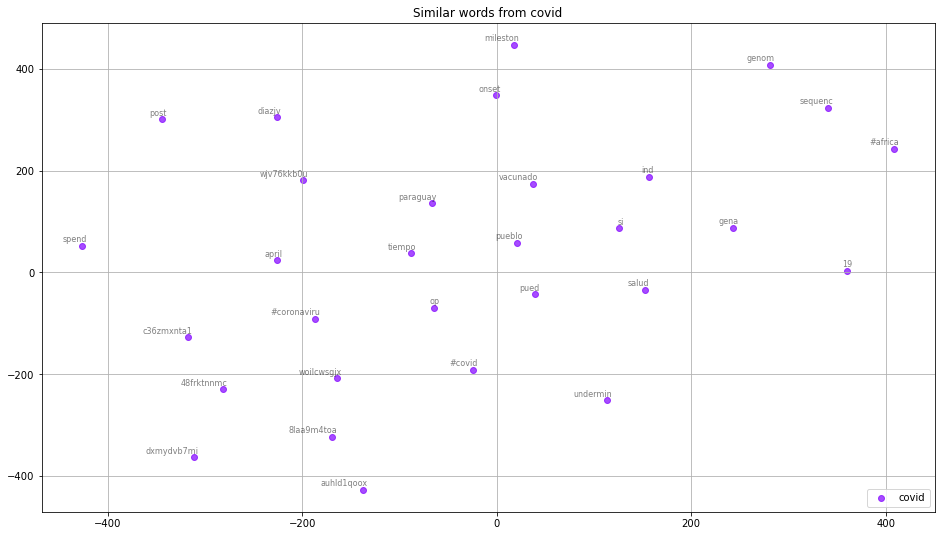

In [34]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from covid', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

 

TSNE(init='pca', n_components=3, n_iter=3500, perplexity=30, random_state=12)


D:\Anaconda\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


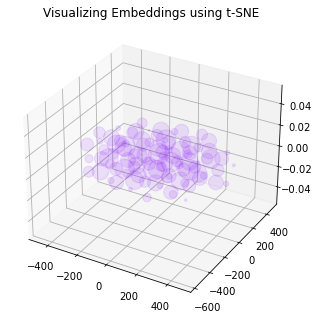

In [35]:
words_wp = []
embeddings_wp = []
for word in list(wordvec_df):
    try:
        embeddings_wp.append(model_w2v.wv[word])
        words_wp.append(word)
    except:
        continue

tsne_wp_3d = TSNE(perplexity=30, n_components=3, init = "pca", n_iter=3500, random_state=12)
print(tsne_wp_3d)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)

    #plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'Covid 19', embeddings_wp_3d, a=0.1)
